In [1]:
import scanpy as sc
from scipy import sparse

import pandas as pd
import matplotlib.pyplot as plt

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

2024-10-29 11:53:22.597540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 11:53:23.426662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 11:53:23.796510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 11:53:25.253686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 11:53:44.519497: W tensorflow/comp

In [2]:
adata = ...

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 30278 × 32285
    obs: 'sample_id', 'manual_celltype_annotation', 'leiden_0.1', 'leiden_0.3', 'leiden_0.5', 'leiden_0.7', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_3', 'disease', 'size_factors', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'manual_celltype_annotation_0.1', 'manual_celltype_annotation_0.5', 'cell_type', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'origin'
    obsm: 'X_umap', 'X_pca', 'Harmony'
    layers: 'counts', 'logcounts'>

In [6]:
list(adata.obs['sample_group'].unique())

['CL0412',
 'CL2',
 'HCM300',
 'HCM456',
 'HCM483',
 'HCM516',
 'HCM534',
 'HCM621',
 'HCM752',
 'HCM763',
 'HCM770',
 'HCM823']

In [7]:
coda_data = dat.from_scanpy(
    adata,
    cell_type_identifier="manual_celltype_annotation",
    sample_identifier="sample_group",
)
print(coda_data)

No covariate information specified!
AnnData object with n_obs × n_vars = 12 × 15
    var: 'n_cells'


In [15]:
# reference condition should be treated/diseased - NOT control
reference_condition = "HCM"

# Fit the model
model = mod.CompositionalAnalysis(coda_data, formula="condition")
result = model.sample_hmc()

Automatic reference selection! Reference cell type set to Lymphatic endothelial cells
Zero counts encountered in data! Added a pseudocount of 0.5.


I0000 00:00:1730203283.665278 1696156 service.cc:146] XLA service 0x7f4e20007f20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730203283.733881 1696156 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-10-29 12:01:24.292327: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730203286.962863 1696156 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|████████████████████████████████████| 20000/20000 [01:02<00:00, 320.79it/s]


MCMC sampling finished. (87.400 sec)
Acceptance rate: 63.9%


In [19]:
result.set_fdr(est_fdr=0.05)

result.intercept_df.to_csv(f"{intercept_df_output}.tsv", sep='\t')
result.effect_df.to_csv(f"{effect_df_output}.tsv", sep='\t')

result.intercept_df.to_excel(f'{intercept_df_output}.xlsx', index=False)
result.effect_df.to_excel(f'{effect_df_output}.xlsx', index=False)

/users/procardis/zlv560/workspace/__PYVENV/skylake/lib/python3.10/site-packages/sccoda/util/data_visualization.py:335: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


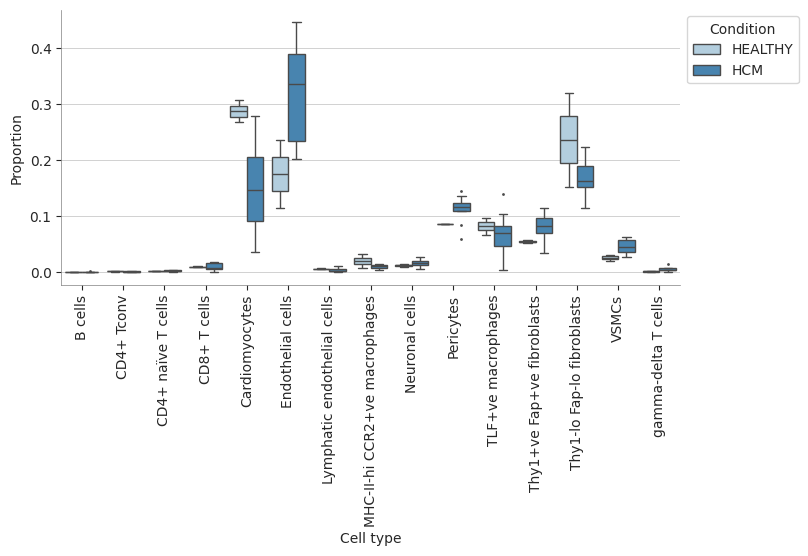

In [17]:
# Assuming viz.boxplots plots the data
viz.boxplots(
    coda_data,
    feature_name="condition",
    plot_facets=False,
    y_scale="relative",
    add_dots=False,
)

# Access the current Axes object
ax = plt.gca()

# Remove the top and right spines (frame)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optionally, make the left and bottom spines less prominent
ax.spines['left'].set_linewidth(0.5)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('gray')

# Set a light grid for better readability, only on the y-axis
ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.set_axisbelow(True)

ax.legend(title='Condition', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the figure size to make the bars appear slimmer
fig = plt.gcf()  # Get the current figure
fig.set_size_inches(9, 7)  # Adjust figure size as needed (width, height)

# Save the figure with the updated aesthetics
plt.savefig(boxplot_output, bbox_inches='tight')

# Show the plot
plt.show()

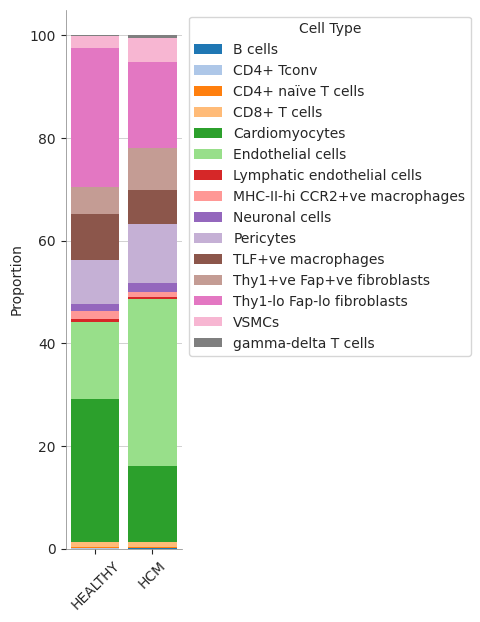

In [18]:
viz.stacked_barplot(coda_data, feature_name="condition")

# Access the current Axes object
ax = plt.gca()

# Attempt to remove the title if it's set via the Axes title
ax.set_title('')

# Remove the top and right spines (frame)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optionally, make the left and bottom spines less prominent
ax.spines['left'].set_linewidth(0.5)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('gray')

# Set a light grid for better readability, only on the y-axis
ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.set_axisbelow(True)

ax.legend(title='Cell Type', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the figure size to make the bars appear slimmer
fig = plt.gcf()  # Get the current figure
fig.set_size_inches(1.5, 7)  # Adjust figure size as needed (width, height)

# Save the figure with the updated aesthetics
plt.savefig(stackedbar_output, bbox_inches='tight')

# Show the plot
plt.show()